## Project: Skin Cancer classification 

In [174]:
#Download the skin cancer dataset first

In [175]:
import numpy as np
from glob import glob
import csv

In [176]:
#Confirm the dataset
files = np.array(glob("../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/*/*/*"))
print('There are %d total images.' % len(files))

There are 2750 total images.


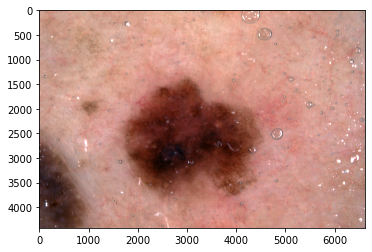

In [177]:
import cv2                
import matplotlib.pyplot as plt 
# load color (BGR) image
img = cv2.imread(files[3])
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)

In [178]:
#Build the model
import torchvision.models as models
import torch.nn as nn
import torch

## TODO: Specify model architecture 
model_transfer=models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False
n_inputs = model_transfer.classifier[6].in_features
#n_inputs is 4096
#final_layer = nn.Sequential(OrderedDict([
#                          ('fc1', nn.Linear(4096, 800)),
#                          ('relu', nn.ReLU()),
#                          ('fc2', nn.Linear(800, 133)),
#                          ('output', nn.LogSoftmax(dim=1))
#                          ]))
final_layer = nn.Linear(n_inputs, 3)
model_transfer.classifier[6] = final_layer
print(final_layer)
print(model_transfer)


Linear(in_features=4096, out_features=3, bias=True)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxP

In [179]:
import os
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

#define training, validation data, test data directories
data_dir = '../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
    
data_transform = transforms.Compose([transforms.RandomResizedCrop(128), 
                                            transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])])
# load and transform data using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))
    
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
print("image number: (train, valid ,test)=",len(train_loader), len(valid_loader),len(test_loader))
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Num training images:  2000
Num validation images:  150
Num test images:  600
image number: (train, valid ,test)= 100 8 30


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


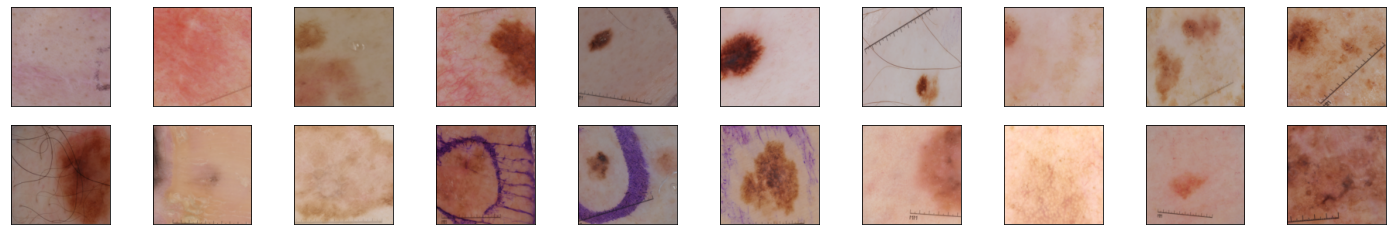

In [180]:
### Visualize some sample data
#See how they look like after transform
#train_loader.size()
# obtain one batch of training images 
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])
dataiter = iter(loaders_transfer['test'])
#print(train_data.shpae)
im, la = dataiter.next()
#print(la)
#print(im.max())
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    tensor = im[idx]
    #print(tensor.max())
    tensor1=inv_normalize(tensor)
   #print(tensor1.max())
    image = tensor1.to("cpu").clone().detach()
    image = tensor1.numpy()
    #print (image.max())
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(image, (1, 2, 0)))

In [181]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print("training begin")
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        #print("begin=",epoch+1)
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #print("Train: batch_idx start",batch_idx)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss +=  ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #print("batch_idx end",batch_idx)
            ### test: shorten the loop
            #if (batch_idx>2):
                #break
        #-------------------------- 
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            #print("Train: batch_idx start",batch_idx)
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            ### test: shorten the loop
            #if (batch_idx>2):
                #break
        #--------------------------    
         #print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [182]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(),lr=0.01)

In [183]:
use_cuda = torch.cuda.is_available()
n_epochs=50
#if use_cuda:
#    model_transfer.cuda()
#model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer
#                        , criterion_transfer, use_cuda, './model_transfer.pt')

In [184]:

if (use_cuda==0):
    model_transfer.load_state_dict(torch.load('your_model_path', map_location=lambda storage, loc: storage))
    #model_transfer.load_state_dict(torch.load('../input/model-new/model-trained.pt', map_location=lambda storage, loc: storage))
    
if use_cuda:
    model_transfer.load_state_dict(torch.load('your_model_path'))
    #model_transfer.load_state_dict(torch.load('../input/model-new/model-trained.pt'))

In [185]:
def test(loaders, model, criterion, use_cuda):
    #model.load_state_dict(torch.load(save_path))
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [186]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.769184


Test Accuracy: 68% (410/600)


In [187]:
data_transfer = {'train': train_data, 'valid': valid_data, 'test': test_data}
class_names= data_transfer['train'].classes
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
print(class_names)

['melanoma', 'nevus', 'seborrheic_keratosis']


In [188]:
import torch.nn.functional as F
#Output the csv file for drawing the ROC curve and consfusion matrix
def output_csv(loaders, model, criterion, use_cuda):
    #soft=F.softmax(dim=1)
    id_count=0
    model.eval()
    collections=[]
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        collection=[]
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        output = F.softmax(output)
        output_t = torch.transpose(output, 0, 1) 
        mela = output_t[0].detach().numpy()
        se = output_t[2].detach().numpy()
        id1=[i for i in range(id_count,id_count+len(output))]
        collection.append(id1)
        collection.append(mela)
        collection.append(se)
        collection=np.transpose(collection)
        id_count+=len(output)
        collections.extend(collection)    
    with open('output.csv','w', newline='') as csvfile1:
            writer=csv.writer(csvfile1)
            writer.writerows(collections)

In [189]:
output_csv(loaders_transfer,model_transfer, criterion_transfer, use_cuda)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [190]:
classnames = ['melanoma', 'nevus', 'seborrheic_keratosis']
#label = [0,1,2]

In [191]:
import sys
from PIL import Image
import torch.nn.functional as F
#Return the 1st and 2nd possible breed of the dog.
def predict_melanoma(model,img_path):
    # load the image
    image1 = Image.open(img_path).convert('RGB')
    in_transform = transforms.Compose([
                        transforms.RandomResizedCrop(128),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    image = in_transform(image1)[:3,:,:].unsqueeze(0)
    #print(image.size())
    #print(image.dim())
    model.eval()
    if use_cuda:
            image = image.cuda()
    output=model(image)
    #m=F.softmax(dim=1)
    output=F.softmax(output,dim=1)
    print(output)
    # Set the threshold here
    if(output[0][0]>0.05):
        result="Positvie"
    else:
        result="Negitvie"
    #Output the figure
    fig = plt.figure(figsize=(10,5))
    ax=fig.add_subplot(1,1,1)
    plt.imshow(image1)
    ax.set_title(result,fontsize=20)
    #ax.set_xlabel(hello1,fontsize=20)
    return result

tensor([[0.0773, 0.8663, 0.0564]], grad_fn=<SoftmaxBackward>)


'Positvie'

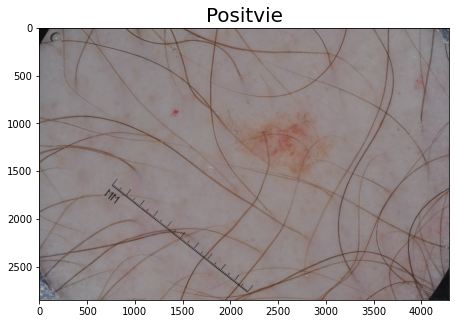

In [192]:
predict_melanoma(model_transfer,"../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test/nevus/ISIC_0012493.jpg")

tensor([[0.2474, 0.6423, 0.1103]], grad_fn=<SoftmaxBackward>)


'Positvie'

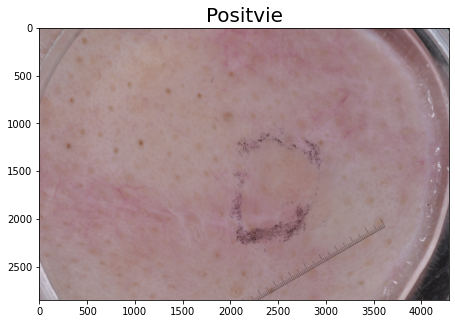

In [193]:
predict_melanoma(model_transfer,"../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test/melanoma/ISIC_0012258.jpg")